# Fitting for $e$ and $w$

In [317]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.constants as c
from tqdm import tqdm
import PyAstronomy.pyasl as pya

import metallicity as mt
import emcee
import corner

np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [10, 5]

In [318]:
def get_T23(p, rp_earth, rs, T14, a, i):
    
    ing_eg = 2*pya.ingressDuration(a, rp_earth*11.2, rs, i, p)#rp needs to in jovian radii
    T23 = T14-ing_eg
    
    return T23

def get_T23_errs(T23_dist):
    
    x, cdf = mt.get_cdf(T23_dist)
    T23_sigma_minus = mt.find_sigma(x, cdf, "-")
    T23_sigma_plus = mt.find_sigma(x, cdf, "+")
    
    return T23_sigma_minus, T23_sigma_plus


def get_planet_params(p, T14, T23):
    """Returns planet parameters in correct units.

    Parameters
    ----------
    p: float
        Planet orbital period (days)
    rp_earth: float
        Planet radius (earth radii)
    rs: float
        Stellar radius (solar radii)
    T14: float
        Total transit time - first to fourth contact (hours)
    a: float
        Planet semi-major axis (AU)
    i: float
        Orbital inclination (degrees)

    Returns
    -------
    p_seconds: float
        Orbital period (seconds)
    rprs: float
        Planet radius (stellar host radii)
    T14_seconds: float
        Total transit time - first to fourth contact (seconds)
    T23_seconds: float
        Full transit time - second to third contact (seconds)
    """

    p_seconds = p*86400
    T14_seconds = T14*3600
    T23_seconds = T23*3600

    return p_seconds, T14_seconds, T23_seconds


def get_rho_circ(rprs, T14, T23, p):
    """Returns stellar density, assuming a perfectly circular planetary orbit.

    Parameters
    ----------
    rprs: float
        Planet radius (stellar host radii)
    T14: float
        Total transit time - first to fourth contact (seconds)
    T23: float
        Full transit time - second to third contact (seconds)
    p: float
        Orbital period (seconds)

    Returns
    -------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    """
    
    delta = rprs**2
    num1 = 2*(delta**(0.25))
    den1 = np.sqrt((T14**2)-(T23**2))
    term1 = (num1/den1)**3

    num2 = 3*p
    den2 = c.G*(c.pi**2)
    term2 = num2/den2

    rho_circ = term1*term2
    
    return rho_circ


def get_g(rho_circ, rho_star):
    """Gets g

    Parameters
    ----------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    rho_star: float
        Stellar density, calculated from Kepler/Gaia/spectroscopy (kg/m^3)

    Returns
    -------
    g: float
        Cube root of ratio between rho_circ and rho_star
    """
    g = np.cbrt(rho_circ/rho_star)
    return g

def get_g_from_def(e, w):
    """Gets g from e and omega

    Parameters
    ----------
    e: float
        Eccentricity
    w: float
        Angle of periapse or something

    Returns
    -------
    g: float
        Cube root of ratio between rho_circ and rho_star
    """ 
    g = (1+e*np.sin(w))/np.sqrt(1-e**2)
    return g


def get_e(g, w):
    """Gets eccentricity (from photoeccentric effect)

    Parameters
    ----------
    g: float
        Cube root of ratio between rho_circ and rho_star
    w: float
        Angle of apoapse or periapse (?) (degrees, -90 < w < 90)

    Returns
    -------
    e: float
        Eccentricity of planet orbit
    """
    e = (np.sqrt(2)*(np.sqrt(2*g**4 - g**2*np.cos(2*w) - g**2 - 2*np.sin(w))))/(2*(g**2 + np.sin(w)**2))
    return e

1. Read in rhos for all Kepler stars with planets (with spectroscopy)
2. Read in all Kepler stars with planets (from exoplanet archive)
3. Take data from (2) for stars in (1)

In [319]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [320]:
spectplanets = spectplanets.reset_index()

In [310]:
def row_to_top(df, index):
    """Bring row to top
    
    Parameters
    ----------
    df: pandas.dataframe
        Dataframe to copy
    index: int
        Index of row to bring to top
        
    Returns
    -------
    df_cp: pandas.dataframe
        Copy of dataframe with specified row at top
    
    """
    df_cp = pd.concat([df.iloc[[index],:], df.drop(index, axis=0)], axis=0)
    return df_cp

In [311]:

def get_g_distribution(row, n_rhos):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    row: int
        Row in pandas.dataframe of info from Exoplanet Archive. (change this to take KIC/KOI)
    n_rhos: int
        Number of values in distribution
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    targ = spectplanets.iloc[row]
    print('KIC: ', targ.kepid)

    rhos = rho_lum[str(targ.kepid)].dropna()
    rhos = np.array(rhos)

    while len(rhos) > n_rhos:
        rhos = np.delete(rhos, [np.random.randint(0, len(rhos))])

    #ws = np.arange(-90., 300., 1.)

    gs = np.zeros((len(rhos)))
    #es = np.zeros(len(rhos))
    #es = np.zeros((len(ws), len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = mt.asymmetric_gaussian(targ.koi_period, targ.koi_period_err1, targ.koi_period_err2, len(rhos))
    
    rs_dist = mt.asymmetric_gaussian(targ.koi_srad, targ.koi_srad_err1, targ.koi_srad_err2, len(rhos))
    rp_earth_dist = mt.asymmetric_gaussian(targ.koi_prad, targ.koi_prad_err1, targ.koi_prad_err2, len(rhos))
    rprs_dist = mt.asymmetric_gaussian(targ.koi_ror, targ.koi_ror_err1, targ.koi_ror_err2, len(rhos))

    T14_dist = mt.asymmetric_gaussian(targ.koi_duration, targ.koi_duration_err1, targ.koi_duration_err2, len(rhos))

    a = targ.koi_sma
    i = targ.koi_incl

    for j in tqdm(range(len(rhos))): #for element in histogram for star:
        T23_dist[j] = get_T23(per_dist[j], rp_earth_dist[j], rs_dist[j], T14_dist[j], a, i)
        
        p_seconds, T14_seconds, T23_seconds = get_planet_params(per_dist[j], T14_dist[j], T23_dist[j])
        rho_circ[j] = get_rho_circ(rprs_dist[j], T14_seconds, T23_seconds, p_seconds)

        rho_ratios[j] = rho_circ[j]/rhos[j]
        g = get_g(rho_circ[j], rhos[j])
        gs[j] = g

    return gs
    

In [325]:
gs_11923270 = get_g_distribution(0, 500)
gs_6435936 = get_g_distribution(5, 500)
gs_7907423 = get_g_distribution(6, 500)

KIC:  11923270


100%|██████████| 500/500 [01:28<00:00,  5.66it/s]


KIC:  6435936


100%|██████████| 500/500 [01:12<00:00,  6.87it/s]


KIC:  7907423


100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


In [251]:
def get_sigmas(dist):
    """Gets + and - sigmas from a distribution (gaussian or not) through a cdf
    
    Parameters
    ----------
    dist: np.array
        Distribution from which sigmas are needed
        
    Returns
    -------
    sigma_minus: float
        - sigma
    sigma_plus: float
        + sigma
    """
    x, cdf = mt.get_cdf(dist)
    sigma_minus = mt.find_sigma(x, cdf, "-")
    sigma_plus = mt.find_sigma(x, cdf, "+")
    
    return sigma_minus, sigma_plus

In [252]:
g_mean = np.mean(gs)
sigma_m, sigma_p = get_sigmas(gs)

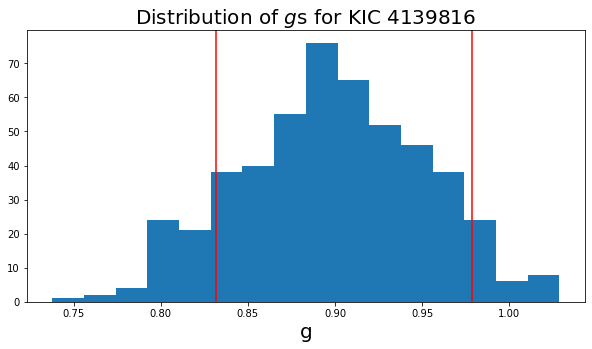

In [253]:
plt.hist(gs, bins='auto');
plt.xlabel('g', fontsize=20)
plt.title('Distribution of $g$s for KIC 4139816', fontsize=20)
plt.axvline(np.mean(gs)-0.067, c='r')
plt.axvline(np.mean(gs)+0.080, c='r')

In [254]:
def get_e_from_def(g, w):
    """Gets eccentricity from definition (eqn 4, not really the definition tho)
    
    Parameters
    ----------
    g: float
        g value
    w: float
        Omega (angle periapse/apoapse)
    
    Returns
    -------
    e: float
        Eccentricity calculated solely on g and w
    
    """
    num = np.sqrt(2)*np.sqrt(2*g**4-g**2*np.cos(2*w)-g**2-2*np.sin(w))
    den = 2*(g**2+np.sin(w)**2)
    e = num/den
    return e

## Finding the allowable (e, w) space for one planet with MCMC

#### For planet with g=0.9

In [255]:
def log_likelihood(theta, g, gerr):
    """Log of likelihood
    model = g(e,w)
    gerr = sigma of g distribution
    """
    w, e = theta
    model = (1+e*np.sin(w))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

In [256]:
def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    w, e = theta
    if 0.0 < e < 1.0 and -90.0 < w < 300.0:
        return 0.0
    return -np.inf

In [257]:
def log_probability(theta, g, gerr):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, g, gerr)

In [289]:
#Guesses
w_guess = 100.0
e_guess = 0.95

solnx = (w_guess, e_guess)

In [290]:
pos = solnx + 1e-4 * np.random.randn(64, 2)
nwalkers, ndim = pos.shape

In [291]:
g_mean = np.mean(gs_4139816)
g_sigma = np.mean(np.abs(get_sigmas(gs)))

#g_mean = 0.4
#g_sigma = 0.05

In [292]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:20<00:00, 489.01it/s]


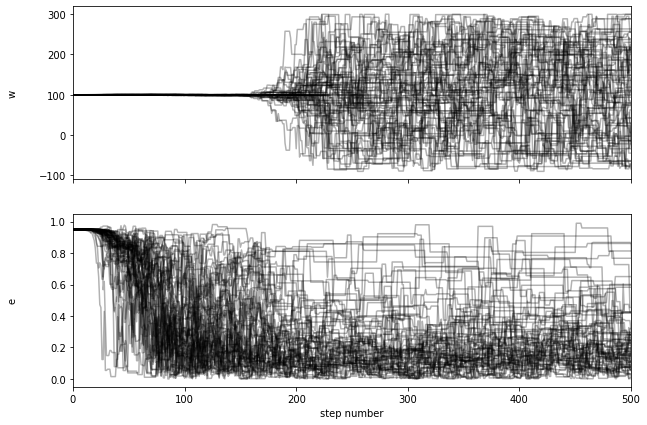

In [293]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

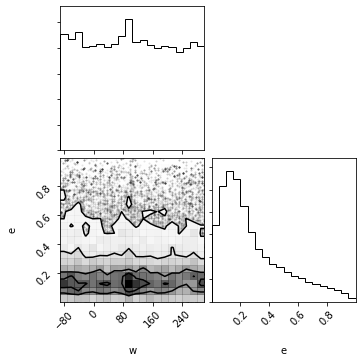

In [294]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

### For planet with g = 1

In [299]:
#Guesses
w_guess = 100.0
e_guess = 0.55

solnx = (w_guess, e_guess)

In [300]:
pos = solnx + 1e-4 * np.random.randn(64, 2)
nwalkers, ndim = pos.shape

In [301]:
g_mean = np.mean(gs_11923270)
g_sigma = np.mean(np.abs(get_sigmas(gs_11923270)))

In [302]:
g_mean

1.0955948896598902

In [303]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:27<00:00, 369.75it/s]


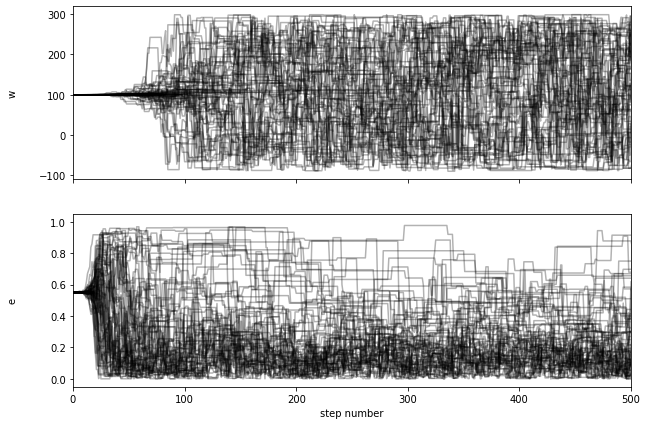

In [304]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

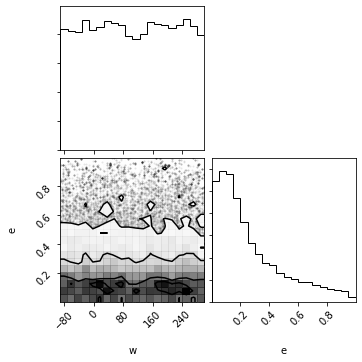

In [305]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

##### Other stuff (attempts to graph gs from (e, w) meshgrid)

In [206]:
e = np.linspace(0.0, 1.0, num=500)
w = np.linspace(-90.0, 300.0, num=500)
W, E = np.meshgrid(w, e)

In [207]:
G = get_g_from_def(E, W)

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in true_divide


In [208]:
for i in range(len(G)):
    for j in range(len(G[0])):
        if g_mean+sigma_m < G[i][j] < g_mean+sigma_p:
            G[i][j] = 1.
        else:
            G[i][j] = 0.

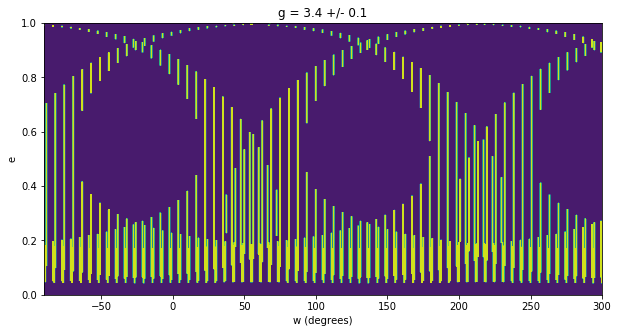

In [209]:
fig, ax = plt.subplots()
CS = ax.contourf(W, E, G)
#ax.clabel(CS, inline=True, fontsize=10)
ax.set_ylabel('e');
ax.set_xlabel('w (degrees)')
ax.set_title('g = 3.4 +/- 0.1');

😈